In [18]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.optimize as optimize
from scipy import stats

# TO DO
1. ogarnać dokładnie kod
2. obliczyć zmienność dla złota żeby mieć potem plot

In [8]:
df = pd.read_csv(r'C:\Users\maxim\Documents\GitHub\gold-forecast\data\data_returns_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])
df.dropna(inplace=True) # I didnt drop the first row after pct_change in data exploration and preparation part, thus dropna here
df.head()

,Gold
date,
1986-01-03,0.001379
1986-01-06,0.003826
1986-01-07,0.006098
1986-01-08,0.007879
1986-01-09,0.002706


In [ ]:
return_array = np.array(df['Gold'])

In [5]:
# GARCH model
def garch_forward(return_rate,variance,coefficients):
    ''' data type: float, float, 1d array(length=3)'''
    
    # Coefficients
    alpha,beta,omega = coefficients
    # Calculate
    return omega + alpha*return_rate*return_rate + beta*variance

In [9]:
initial_variance = df['Gold'][0]-df['Gold'].mean()

0.001139138054609441

In [23]:
# Function for optimization

def garch_for_optimization(array): 
    ''' data type: 1d array(length=3)'''
    
    # Coeffcients
    alpha,beta,omega = array 
    
    # Variables
    sum_probability = 0 # to maximize
    variance = initial_variance
    
    for i in range(1,return_array.shape[0]):  # exclude the first value because it's nan.
        return_rate = return_array[i]  
        
        # in case something goes wrong
        if variance<=0:
            print("Negative variance")
            break
        
        # calculate probability in a single day
        probability = -np.log(variance) - return_rate * return_rate / variance
        
        # add to the sum
        sum_probability += probability
        
        # calculate next day's variance by GARCH
        variance = garch_forward(return_rate,variance,array)
   
    return -sum_probability # note the sign(-); because scipy.optimize requires a function to be minimized

In [24]:
# Optimize
# if execute is set TRUE, optimization which takes some time will be initiated
execute = True    

if execute:
    bounds = optimize.Bounds([0,0,0],[1,1,np.inf])
    initial_guess = [0.14,0.76,2.97]  # V-Lab's estimate

    # Trust-constr performed the best 
    optimize_res_trust = optimize.minimize(garch_for_optimization,initial_guess,method='trust-constr',bounds=bounds)

Negative variance
Negative variance
Negative variance
Negative variance


c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [25]:
print('optimization result:')
print('alpha =',optimize_res_trust.x[0])
print('beta =',optimize_res_trust.x[1])
print('omega =',optimize_res_trust.x[2])

optimization result:
alpha = 0.05417093435586603
beta = 0.9435152559424961
omega = 5.201357725771324e-07


In [26]:
# Estimate historical volatility with estimated coefficients

variance_array = np.zeros(df.shape[0],)  # Create array to store variance

# Values to be pre-assigned
variance_array[0] = np.nan  # Historical volatility cannot be estimated for the first one in full_data (06/03/2009)
variance_array[1] = initial_variance 

# Calculate historical volatilities using GARCH
for i in range(2,df.shape[0]):
    variance_array[i]=garch_forward(return_array[i-1],variance_array[i-1],optimize_res_trust.x)
    
# Adjust value to compare with VKOSPI (elaborated in 2-3-2)  
historical_volatility = np.sqrt(variance_array * 252) * 100

# Add to the dataset
df['Historical Volatility'] = historical_volatility
full_data = df.dropna()  # Drop NA (because of nan in historical volatility)

In [27]:
# Before visualizing, few matplotlib settings
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['axes.labelpad'] = 5.5  # space between axis and label
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titlepad'] = '20.0'

mpl.rcParams['legend.fontsize'] = 'x-large'

# mpl color settings
default_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

# and seaborn settings
sns.set_style('darkgrid')

In [29]:
full_data

,Gold,Historical Volatility
date,,
1986-01-06,0.003826,53.578241
1986-01-07,0.006098,52.074848
1986-01-08,0.007879,50.645842
1986-01-09,0.002706,49.294041
1986-01-10,0.020840,47.905745
...,...,...
2022-12-30,0.000000,14.812683
2023-01-03,0.016265,14.433734
2023-01-04,0.007622,15.296672


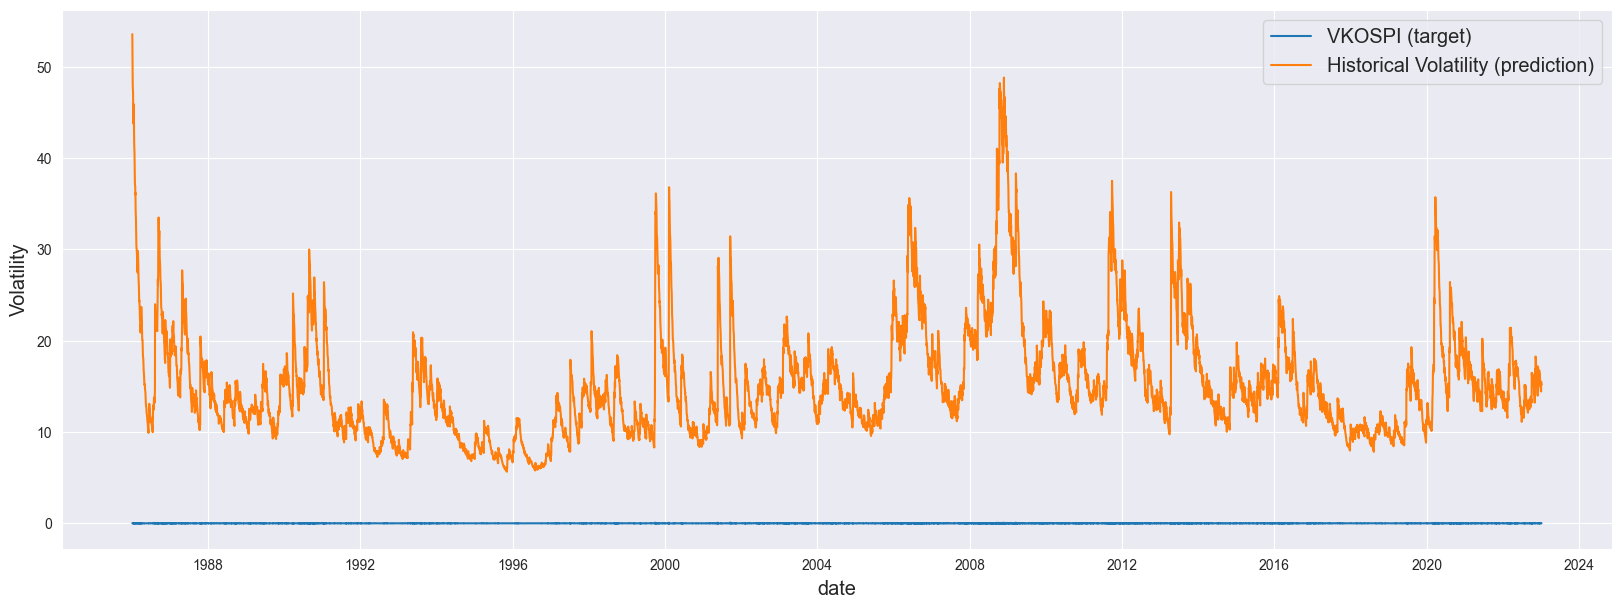

In [31]:
# Compare with VKOSPI (Visualization)
pd.plotting.register_matplotlib_converters()  # because of compatilbility issue with pd.Timestamp and matplotlib

fig, ax = plt.figure(figsize=(20,7)), plt.axes()
sns.lineplot(data=full_data,x=full_data.index ,y='Gold',label='VKOSPI (target)',ax=ax)
sns.lineplot(data=full_data,x=full_data.index,y='Historical Volatility',label='Historical Volatility (prediction)',ax=ax)
plt.ylabel('Volatility')
plt.show()

----


In [15]:
import os
os.getcwd() # cwd needs to be just in the gold-forecast folder

'e:\\Dokumenty\\GitHub\\gold-forecast'

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.optimize as optimize
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from arch import arch_model
import math

In [3]:
import os
os.getcwd()

'e:\\Dokumenty\\GitHub\\gold-forecast\\Models\\Volatility'

In [5]:
os.chdir('..')
os.chdir('..')
os.getcwd()

'e:\\Dokumenty\\GitHub\\gold-forecast'

In [6]:
df = pd.read_csv('data/data_returns_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])
df.dropna(inplace=True) 

Text(0.5, 1.0, 'Gold returns per troy oz 1986-01-02 to 2023-01-06')

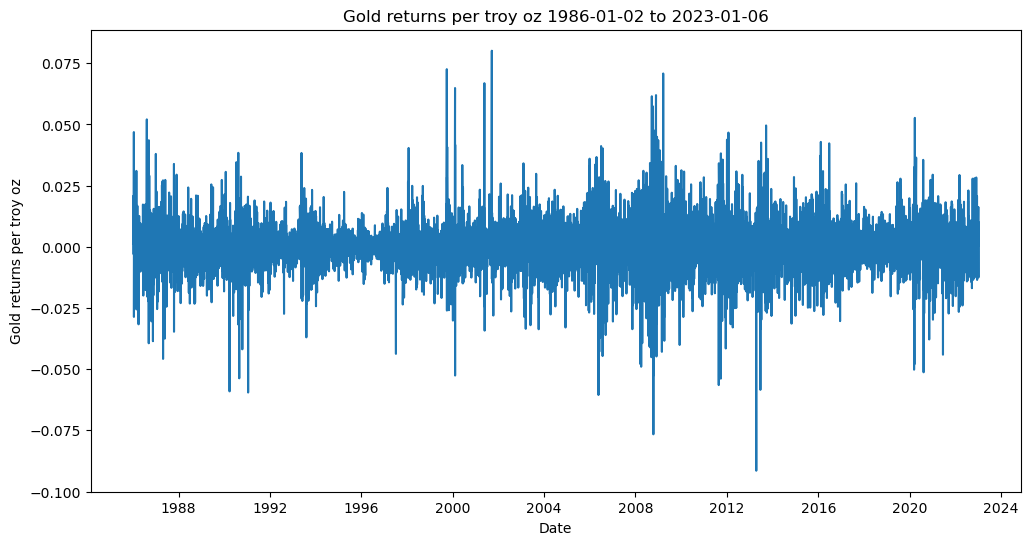

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=df.index, y='Gold', data=df, ax=ax)
ax.set_ylabel('Gold returns per troy oz')
ax.set_xlabel('Date')
ax.set_title('Gold returns per troy oz 1986-01-02 to 2023-01-06')

e:\anaconda\envs\thesis\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


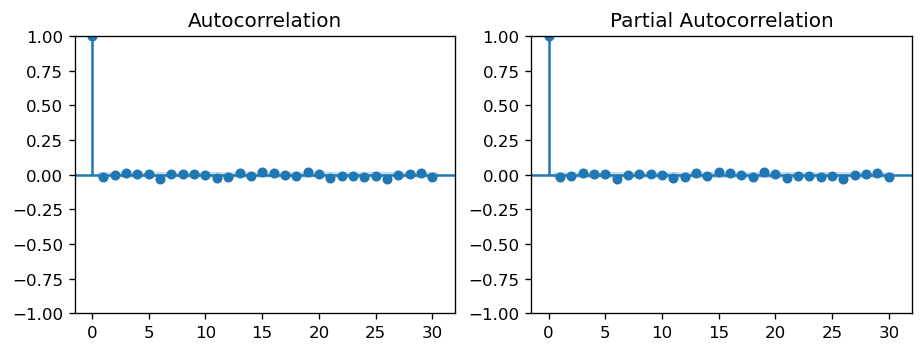

In [18]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
plot_acf(df['Gold'], ax=axes[0], lags=30)
plot_pacf(df['Gold'], ax=axes[1], lags=30)

plt.show()

In [21]:
#The daily volatility is the std of the returns
daily_volatility = df['Gold'].std()
#The monthly volatility is the result of multiplying the daily vol * square root of 21, this is because there are 21 trading days in a month
monthly_volatility = math.sqrt(21) * daily_volatility
#The annual volatility is the result of multiplying the daily vol * square root of 252, this is because there are 252 trading days in a year
annual_volatility = math.sqrt(252) * daily_volatility
#Using tabulate package we can print a nice table
print('Gold',daily_volatility,monthly_volatility,annual_volatility)

Gold 0.010011944637023418 0.045880494152866984 0.15893469389826484


## GARCH model

In [14]:
#Define a GARCH model
model = arch_model(df['Gold'],dist="Normal", vol = 'GARCH', p=4, q=4)
#Fit the model
model_fit = model.fit(disp='off')
#Summary of the model
model_fit.summary()

NameError: name 'arch_model' is not defined

In [ ]:
forecasts = model_fit.forecast(horizon=30, reindex=False)